In [1]:
# default_exp models.nbeats.nbeats

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import os
import time
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import copy

import torch as t
from torch import optim
from pathlib import Path
from functools import partial

from nixtla.models.nbeats.nbeats_model import NBeats, NBeatsBlock, IdentityBasis, TrendBasis, SeasonalityBasis
from nixtla.models.nbeats.nbeats_model import ExogenousBasisInterpretable, ExogenousBasisWavenet, ExogenousBasisTCN
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss, PinballLoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse, pinball_loss


In [4]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

class Nbeats(object):
    """
    Future documentation
    """
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    IDENTITY_BLOCK = 'identity'

    def __init__(self,
                 input_size_multiplier,
                 output_size,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_hidden,
                 n_harmonics,
                 n_polynomials,
                 exogenous_n_channels,
                 include_var_dict,
                 t_cols,
                 batch_normalization,
                 dropout_prob_theta,
                 dropout_prob_exogenous,
                 x_s_n_hidden,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 l1_theta,
                 n_iterations,
                 early_stopping,
                 loss,
                 loss_hypar,
                 val_loss,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(Nbeats, self).__init__()

        if activation == 'selu': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.input_size = int(input_size_multiplier*output_size)
        self.output_size = output_size
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.exogenous_n_channels = exogenous_n_channels

        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta
        self.dropout_prob_exogenous = dropout_prob_exogenous
        self.x_s_n_hidden = x_s_n_hidden
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.loss_hypar = loss_hypar
        self.val_loss = val_loss
        self.l1_theta = l1_theta
        self.l1_conv = 1e-3 # Not a hyperparameter
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.seasonality = seasonality        
        self.include_var_dict = include_var_dict
        self.t_cols = t_cols
        #self.scaler = scaler

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def create_stack(self):
        if self.include_var_dict is not None:
            x_t_n_inputs = self.output_size * int(sum([len(x) for x in self.include_var_dict.values()]))
            
            # Correction because week_day only adds 1 no output_size
            if len(self.include_var_dict['week_day'])>0:
                x_t_n_inputs = x_t_n_inputs - self.output_size + 1 
        else:
            x_t_n_inputs = self.input_size
        
        #------------------------ Model Definition ------------------------#
        block_list = []
        self.blocks_regularizer = []
        for i in range(len(self.stack_types)):
            #print(f'| --  Stack {self.stack_types[i]} (#{i})')
            for block_id in range(self.n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (self.batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False
                
                # Dummy of regularizer in block. Override with 1 if exogenous_block
                self.blocks_regularizer += [0]

                # Shared weights
                if self.shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if self.stack_types[i] == 'seasonality':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=4 * int(
                                                        np.ceil(self.n_harmonics / 2 * self.output_size) - (self.n_harmonics - 1)),
                                                   basis=SeasonalityBasis(harmonics=self.n_harmonics,
                                                                          backcast_size=self.input_size,
                                                                          forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'trend':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2 * (self.n_polynomials + 1),
                                                   basis=TrendBasis(degree_of_polynomial=self.n_polynomials,
                                                                            backcast_size=self.input_size,
                                                                            forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'identity':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=self.input_size + self.output_size,
                                                   basis=IdentityBasis(backcast_size=self.input_size,
                                                                       forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*self.n_x_t,
                                                   basis=ExogenousBasisInterpretable(),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_tcn':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden = self.x_s_n_hidden,
                                                   theta_n_dim = 2*(self.exogenous_n_channels),
                                                   basis= ExogenousBasisTCN(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_wavenet':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*(self.exogenous_n_channels),
                                                   basis=ExogenousBasisWavenet(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                        self.blocks_regularizer[-1] = 1
                    else:
                        assert 1<0, f'Block type not found!'
                # Select type of evaluation and apply it to all layers of block
                init_function = partial(init_weights, initialization=self.initialization)                                             
                nbeats_block.layers.apply(init_function)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def __loss_fn(self, loss_name: str):
        def loss(x, loss_hypar, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=loss_hypar, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'PINBALL':
                return PinballLoss(y=target, y_hat=forecast, mask=mask, tau=loss_hypar) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'PINBALL':
                return pinball_loss(y=target, y_hat=forecast, weights=weights, tau=0.5)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss
    
    def loss_l1_conv_layers(self):
        loss_l1 = 0
        for i, indicator in enumerate(self.blocks_regularizer):
            if indicator:
                loss_l1 += self.l1_conv * t.sum(t.abs(self.model.blocks[i].basis.weight))
        return loss_l1
    
    def loss_l1_theta(self):
        loss_l1 = 0
        for block in self.model.blocks:
            for layer in block.modules():
                if isinstance(layer, t.nn.Linear):
                    loss_l1 += self.l1_theta * layer.weight.abs().sum()
        return loss_l1

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def evaluate_performance(self, ts_loader, validation_loss_fn):
        self.model.eval()

        #losses = []
        forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast   = self.model(x_s=s_matrix, insample_y=insample_y, 
                                        insample_x_t=insample_x, outsample_x_t=outsample_x,
                                        insample_mask=insample_mask)
                #batch_loss = validation_loss_fn(target=outsample_y.cpu().data.numpy(),
                #                                forecast=forecast.cpu().data.numpy(),
                #                                weights=outsample_mask.cpu().data.numpy())
                #losses.append(batch_loss)
                forecasts.append(forecast.cpu().data.numpy())
                outsample_ys.append(batch['outsample_y'])
                outsample_masks.append(batch['outsample_mask'])

        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)
        #loss = np.mean(losses)

        complete_loss = validation_loss_fn(target=outsample_ys,
                                           forecast=forecasts,
                                           weights=outsample_masks)

        self.model.train()
        return complete_loss

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_steps=1):
        # TODO: Indexes hardcoded, information duplicated in train and val datasets
        assert (self.input_size)==train_ts_loader.input_size, \
            f'model input_size {self.input_size} data input_size {train_ts_loader.input_size}'

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_x_t, self.n_x_s = train_ts_loader.get_n_variables()

        # Instantiate model
        if not self._is_instantiated:
            block_list = self.create_stack()
            self.model = NBeats(t.nn.ModuleList(block_list)).to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.val_loss) #Uses numpy losses

        print('='*30+' Start fitting '+'='*30)

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None
        
        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_state_dict = copy.deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue

                self.model.train()
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                optimizer.zero_grad()
                forecast   = self.model(x_s=s_matrix, insample_y=insample_y, 
                                        insample_x_t=insample_x, outsample_x_t=outsample_x,
                                        insample_mask=insample_mask)

                training_loss = training_loss_fn(x=insample_y, loss_hypar=self.loss_hypar, forecast=forecast,
                                                 target=outsample_y, mask=outsample_mask)

                if np.isnan(float(training_loss)):
                    break

                training_loss.backward()
                t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                lr_scheduler.step()
                if (iteration % eval_steps == 0):
                    display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                            time.time()-start,
                                                                                            self.loss,
                                                                                            training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(np.float(training_loss.cpu().data.numpy()))

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                         validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.val_loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = copy.deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True
                    
                    print(display_string)

                    self.model.train()

                if break_flag:
                    print('\n')
                    print(19*'-',' Stopped training by early stopping', 19*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations >0:
            # This is batch loss!
            self.final_insample_loss = np.float(training_loss.cpu().data.numpy()) if not break_flag else best_insample_loss 
            string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.val_loss, self.final_outsample_loss)
            print(string)
            print('='*30+'  End fitting  '+'='*30)
            print('\n')

    def predict(self, ts_loader, X_test=None, eval_mode=False):
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'

        forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model(insample_y=insample_y, insample_x_t=insample_x,
                                      insample_mask=insample_mask, outsample_x_t=outsample_x, x_s=s_matrix)
                forecasts.append(forecast.cpu().data.numpy())
                outsample_ys.append(batch['outsample_y'])
                outsample_masks.append(batch['outsample_mask'])
        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        self.model.train()
        if eval_mode:
            return outsample_ys, forecasts, outsample_masks

        # Pandas wrangling
        frequency = ts_loader.get_frequency()
        unique_ids = ts_loader.get_meta_data_col('unique_id')
        last_ds = ts_loader.get_meta_data_col('last_ds') #TODO: ajustar of offset

        # Predictions for panel
        Y_hat_panel = pd.DataFrame(columns=['unique_id', 'ds'])
        for i, unique_id in enumerate(unique_ids):
            Y_hat_id = pd.DataFrame([unique_id]*self.output_size, columns=["unique_id"])
            ds = pd.date_range(start=last_ds[i], periods=self.output_size+1, freq=frequency)
            Y_hat_id["ds"] = ds[1:]
            Y_hat_panel = Y_hat_panel.append(Y_hat_id, sort=False).reset_index(drop=True)

        Y_hat_panel['y_hat'] = forecasts.flatten()

        if X_test is not None:
            Y_hat_panel = X_test.merge(Y_hat_panel, on=['unique_id', 'ds'], how='left')
        
        return Y_hat_panel


    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

# SINGLE TIME SERIES TEST

In [5]:
import matplotlib.pyplot as plt

from nixtla.data.scalers import Scaler
from nixtla.data.tsdataset import TimeSeriesDataset as TimeSeriesDataset
from nixtla.data.tsloader_fast import TimeSeriesLoader
#from nixtla.data.tsloader_general import TimeSeriesLoader

from nixtla.data.datasets.epf import EPF, EPFInfo

# Hacked MAE NP hypars
hacked_np = {'input_size_multiplier': 7,
             'output_size': 24,
             'window_sampling_limit': 365*4*24,
             'idx_to_sample_freq': 24,
             'batch_size': 256,
             'shared_weights': False,
             'activation': 'relu',
             'initialization': 'he_normal',
             'stack_types': ['exogenous_tcn']+1*['identity'],
             'n_blocks': 2*[1],
             'n_layers': 2*[2],
             'n_hidden': 2*[[462,462]],
             'n_polynomials': 2,
             'n_harmonics': 1,
             'exogenous_n_channels': 8,
             'include_var_dict': {'y': [-2, -3, -8],
                                  'Exogenous1': [-1, -2, -8],
                                  'Exogenous2': [-1, -2, -8],
                                  'week_day': [-1]},
             'batch_normalization': False,
             'dropout_prob_theta': 0.05,
             'dropout_prob_exogenous': 0.35,
             'x_s_n_hidden': 0,
             'learning_rate': 0.0016,
             'lr_decay': 0.5,
             'n_lr_decay_steps': 3,
             'weight_decay': 6e-4,
             'l1_theta': 1.0e-05,
             'n_iterations': 200, #2000 <-------------
             'early_stopping': 40,
             'loss': 'PINBALL',
             'loss_hypar': 0.49,
             'val_loss': 'MAE',
             'frequency': 'H',
             'random_seed': 17,
             'seasonality': 24}

# Hacked MAE BE hypars
hacked_be = {'input_size_multiplier': 7,
             'output_size': 24,
             'window_sampling_limit': 365*4*24,
             'idx_to_sample_freq': 24,
             'batch_size': 256,
             'shared_weights': False,
             'activation': 'relu',
             'initialization': 'lecun_normal',
             'stack_types': ['exogenous_wavenet']+1*['identity'],
             'n_blocks': 2*[1],
             'n_layers': 2*[2],
             'n_hidden': 2*[[462,462]],
             'n_polynomials': 2,
             'n_harmonics': 1,
             'exogenous_n_channels': 8,
             'include_var_dict': {'y': [-2, -3, -8],
                                  'Exogenous1': [-1, -2, -8],
                                  'Exogenous2': [-1, -2, -8],
                                  'week_day': [-1]},
             'batch_normalization': False,
             'dropout_prob_theta': 0.14,
             'dropout_prob_exogenous': 0.08, #<-------- Interesante
             'x_s_n_hidden': 0,
             'learning_rate': 0.0013,
             'lr_decay': 0.5,
             'n_lr_decay_steps': 3,
             'weight_decay': 0.0017,
             'l1_theta': 1.5e-05,
             'n_iterations': 200, #2000 <-------------
             'early_stopping': 40,
             'loss': 'PINBALL',
             'loss_hypar': 0.502,
             'val_loss': 'MAE',
             'frequency': 'H',
             'random_seed': 16,
             'seasonality': 24}

mc = hacked_np
#mc = hacked_be

In [6]:
def forecast_evaluation_table(y_true, y_hat):
    y_true = y_true.reshape(-1)
    y_hat = y_hat.reshape(-1)
    
    #_pinball50 = np.round(pinball_loss(y_true, y_hat, tau=0.5),5)
    _mae   = np.round(mae(y_true, y_hat),5)
    _mape  = np.round(mape(y_true, y_hat),5)
    _smape = np.round(smape(y_true, y_hat),5)
    _rmse  = np.round(rmse(y_true, y_hat),5)

    performance = pd.DataFrame({'metric': ['mae', 'mape', 'smape', 'rmse'],
                                'measure': [_mae, _mape, _smape, _rmse]})                          

    return performance

def get_last_n_hours_mask_df(Y_df, n_hours):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_hours)
    last_df['mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['mask'] = mask_df['mask'].fillna(1)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

def run_val_nbeatsx(mc, Y_df, Xt_df, S_df, mask_df, val_ds): #, trials, trials_file_name):

    #---------------------------------------------- Read  Data ----------------------------------------------#

    # To not modify original data
    Xt_scaled_df = Xt_df.copy()

    # Transform data with scale transformation
    scaler = Scaler(normalizer='norm')
    Xt_scaled_df['Exogenous1'] = scaler.scale(x=Xt_scaled_df['Exogenous1'].values, offset=val_ds*24)

    scaler = Scaler(normalizer='norm')
    Xt_scaled_df['Exogenous2'] = scaler.scale(x=Xt_scaled_df['Exogenous2'].values, offset=val_ds*24)

    #print(f'Dataset: {args.dataset}')
    #print("Xt_df.columns", Xt_df.columns)
    print('X: time series features, of shape (#hours, #times,#features): \t' + str(Xt_df.shape))
    if S_df is not None:
        print('S: static features, of shape (#series,#features+unique_id): \t' + str(S_df.shape))
    print('Y: target series (in X), of shape (#hours, #times): \t \t' + str(Y_df.shape))
    print("\n")

    print("Train Validation splits")
    mask = mask_df['mask'].values
    print(mask_df.groupby(['unique_id', 'mask']).agg({'ds': ['min', 'max']}))
    print(f'Train insample percentage {np.round(sum(mask)/len(Y_df),2)}, \
            {sum(mask)} hours = {np.round(sum(mask)/(24*365),2)} years')
    print(f'Train outsample percentage {np.round(sum(1-mask)/len(Y_df),2)}, \
            {sum(1-mask)} hours = {np.round(sum(1-mask)/(24*365),2)} years')
    #Y_df.head()
    print('\n')

    ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=S_df, X_df=Xt_scaled_df, mask_df=mask_df)

    train_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                                    model='nbeats',
                                    offset=0, #offset,
                                    window_sampling_limit=int(mc['window_sampling_limit']), 
                                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                    output_size=int(mc['output_size']),
                                    idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                    batch_size=int(mc['batch_size']),
                                    is_train_loader=True,
                                    shuffle=True)

    val_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                                    model='nbeats',
                                    offset=0, #offset,
                                    window_sampling_limit=int(mc['window_sampling_limit']), 
                                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                    output_size=int(mc['output_size']),
                                    idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                    batch_size=1024,
                                    is_train_loader=False, # Samples the opposite of train_outsample_mask
                                    shuffle=False)                                  

    #-------------------------------------- Hyperparameter Optimization --------------------------------------#

    model = Nbeats(input_size_multiplier=int(mc['input_size_multiplier']),
                    output_size=int(mc['output_size']),
                    shared_weights=int(mc['shared_weights']),
                    activation=mc['activation'],
                    initialization=mc['initialization'],
                    stack_types=mc['stack_types'], #2*['identity'],
                    n_blocks=mc['n_blocks'], #2*[1],
                    n_layers=mc['n_layers'], #2*[2],
                    n_hidden=mc['n_hidden'], #2*[[256,256]],
                    n_polynomials=mc['n_polynomials'], #2,
                    n_harmonics=int(mc['n_harmonics']), #1,
                    exogenous_n_channels=int(mc['exogenous_n_channels']), #9,
                    include_var_dict={'y': [-2, -3, -8],
                                        'Exogenous1': [-1, -2, -8],
                                        'Exogenous2': [-1, -2, -8],
                                        'week_day': [-1]},
                    t_cols=ts_dataset.t_cols,
                    batch_normalization=mc['batch_normalization'], #False,
                    dropout_prob_theta=float(mc['dropout_prob_theta']), #0.01,
                    dropout_prob_exogenous=float(mc['dropout_prob_exogenous']), #0.01,
                    x_s_n_hidden=int(mc['x_s_n_hidden']), #0,
                    learning_rate=float(mc['learning_rate']), #0.007,
                    lr_decay=float(mc['lr_decay']), #0.5,
                    n_lr_decay_steps=int(mc['n_lr_decay_steps']), #3,
                    weight_decay=float(mc['weight_decay']), #0.0000001,
                    l1_theta=float(mc['l1_theta']), #0.0001,
                    n_iterations=int(mc['n_iterations']), #200,
                    early_stopping=int(mc['early_stopping']), #40,
                    loss=mc['loss'], #'PINBALL',
                    loss_hypar=float(mc['loss_hypar']), #0.5,
                    val_loss=mc['val_loss'], #MAE
                    frequency=mc['frequency'], #'H',
                    random_seed=int(mc['random_seed']), #1,
                    seasonality=int(mc['seasonality'])) #24)

    model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, verbose=True, eval_steps=10)

    print('Best Model Evaluation')
    y_true, y_hat, _ = model.predict(ts_loader=val_loader, eval_mode=True)
    print(forecast_evaluation_table(y_true, y_hat))

    return model, train_loader, val_loader

In [7]:
from nixtla.data.datasets.epf import EPF, EPFInfo

dataset = 'NP'
Y_df, Xt_df = EPF.load(directory='../data/', group=dataset)
val_ds = 365*2
mask_df = get_last_n_hours_mask_df(Y_df, n_hours=val_ds*24)

model, train_loader, val_loader = run_val_nbeatsx(mc, Y_df, Xt_df, S_df=None, mask_df=mask_df, val_ds=val_ds)

X: time series features, of shape (#hours, #times,#features): 	(34944, 12)
Y: target series (in X), of shape (#hours, #times): 	 	(34944, 3)


Train Validation splits
                       ds                    
                      min                 max
unique_id mask                               
NP        0.0  2014-12-28 2016-12-26 23:00:00
          1.0  2013-01-01 2014-12-27 23:00:00
Train insample percentage 0.5,             17424.0 hours = 1.99 years
Train outsample percentage 0.5,             17520.0 hours = 2.0 years


Processing dataframes ...
Creating ts tensor ...
============================== Start fitting ==============================
Step: 10, Time: 1.988, Insample PINBALL: 15.36776, Outsample MAE: 18.73587
Step: 20, Time: 3.950, Insample PINBALL: 2.82169, Outsample MAE: 3.89578
Step: 30, Time: 5.968, Insample PINBALL: 2.72608, Outsample MAE: 2.56092
Step: 40, Time: 7.858, Insample PINBALL: 1.68234, Outsample MAE: 2.50955
Step: 50, Time: 9.719, Insample PINBALL: 1

y_hat.shape  		(#fcds, #lt) 	 (17520,)
y_plot.shape 		(#fcds,) 	 (17520,)




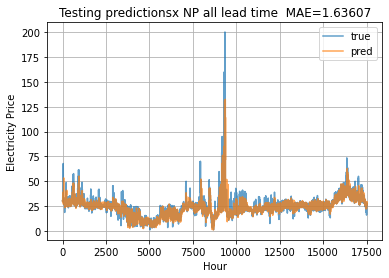

In [8]:
y_true, y_hat, _ = model.predict(ts_loader=val_loader, eval_mode=True)
y_plot = Y_df['y'][-len(y_hat)*24:] #[-2*168:]
y_hat = y_hat.reshape(-1)#[-2*168:]
#lead_time = 23
#y_hat_plot1 = y_hat[-2*168:, lead_time] # Forecast lead_time=?, for the last week
#y_hat_plot2 = y_hat[-1, :]
#y_hat_plot = np.concatenate([y_hat_plot1, y_hat_plot2])

print("y_hat.shape  \t\t(#fcds, #lt) \t", y_hat.shape)
print("y_plot.shape \t\t(#fcds,) \t", y_plot.shape)
#print("y_true.shape \t\t(#fcds,) \t", y_true.shape)
# print("y_hat_plot1.shape \t(#fcds, lt=0) \t", y_hat_plot1.shape)
# print("y_hat_plot2.shape \t(#fcds, lt=0) \t", y_hat_plot2.shape)
print("\n")

performance = np.round(mae(y_plot, y_hat), 5)
plt.plot(range(len(y_plot)), y_plot, label='true', alpha=0.7)
plt.plot(range(len(y_hat)), y_hat, label='pred', alpha=0.7)
plt.title(f"Testing predictionsx {dataset} all lead time  MAE={performance}")
plt.xlabel('Hour')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid()
plt.show()

# MULTIVARIATE TIME SERIES TEST

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from nixtla.data.scalers import Scaler
from nixtla.data.tsdataset import TimeSeriesDataset
# from nixtla.data.tsloader_fast import TimeSeriesLoader
from nixtla.data.tsloader_general import TimeSeriesLoader

from nixtla.data.datasets.epf import EPF, EPFInfo

val_ds = 2 * 365
args = pd.Series({'dataset': ['NP', 'PJM', 'BE', 'FR']})

Y_df, Xt_df, S_df = EPF.load_groups(directory='data', groups=args.dataset)
val_ds = 365*2
mask_df = get_last_n_hours_mask_df(Y_df, n_hours=val_ds*24)

model, train_loader, val_loader = run_val_nbeatsx(mc, Y_df, Xt_df, S_df=S_df, mask_df=mask_df, val_ds=val_ds)

X: time series features, of shape (#hours, #times,#features): 	(139776, 12)
S: static features, of shape (#series,#features+unique_id): 	(4, 5)
Y: target series (in X), of shape (#hours, #times): 	 	(139776, 3)


Train Validation splits
                       ds                    
                      min                 max
unique_id mask                               
BE        0.0  2013-01-04 2015-01-03 23:00:00
          1.0  2011-01-09 2013-01-03 23:00:00
FR        0.0  2013-01-04 2015-01-03 23:00:00
          1.0  2011-01-09 2013-01-03 23:00:00
NP        0.0  2014-12-28 2016-12-26 23:00:00
          1.0  2013-01-01 2014-12-27 23:00:00
PJM       0.0  2014-12-28 2016-12-26 23:00:00
          1.0  2013-01-01 2014-12-27 23:00:00
Train insample percentage 0.5,             69696.0 hours = 7.96 years
Train outsample percentage 0.5,             70080.0 hours = 8.0 years


Processing dataframes ...
Creating ts tensor ...
============================== Start fitting =====================

y_hat.shape  		(#fcds, #lt) 	 (4, 730, 24)
y_true.shape 		(#fcds,) 	 (4, 730, 24)
y_hat_plot.shape  	(#fcds,) 	 (17520,)
y_true_plot.shape 	(#fcds,) 	 (17520,)




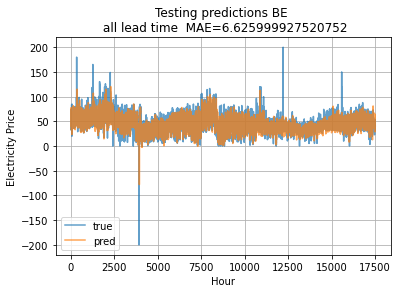

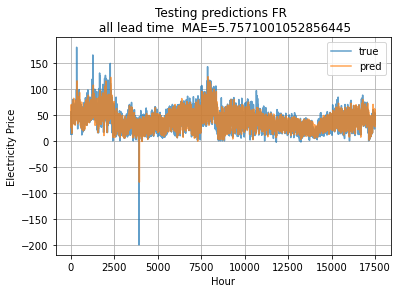

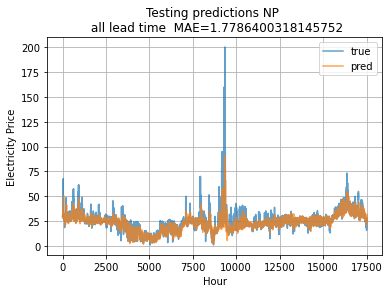

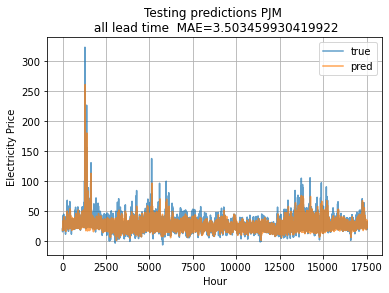

,id,unique_id,metric,dnn,nbeatsx,perc_diff,improvement
0,1,NP,MAE,1.67,1.77864,6.505391,False
1,1,NP,MAPE,5.38,7.82797,45.501301,False
2,1,NP,SMAPE,4.85,7.86596,62.184742,False
3,1,NP,RMSE,3.33,4.07903,22.493393,False
4,2,PJM,MAE,2.78,3.50346,26.023739,False
5,2,PJM,MAPE,28.66,20.62204,-28.045918,True
6,2,PJM,SMAPE,11.22,12.16559,8.427718,False
7,2,PJM,RMSE,4.64,7.61867,64.195474,False
8,3,BE,MAE,5.82,6.62600,13.848796,False
9,3,BE,MAPE,26.11,68.19786,161.194408,False


In [10]:
y_true, y_hat, _ = model.predict(ts_loader=val_loader, eval_mode=True)
y_true = y_true.reshape(4, 2920//4, 24)
y_hat  = y_hat.reshape(4, 2920//4, 24)

print("y_hat.shape  \t\t(#fcds, #lt) \t", y_hat.shape)
print("y_true.shape \t\t(#fcds,) \t", y_true.shape)

y_hat_plot = y_hat[2,:,:].reshape(-1)
y_true_plot = y_true[2,:,:].reshape(-1)

print("y_hat_plot.shape  \t(#fcds,) \t", y_hat_plot.shape)
print("y_true_plot.shape \t(#fcds,) \t", y_true_plot.shape)
print("\n")

performance_df = {'unique_id': [], 'metric': [], 'nbeatsx': []}
for i, meta_data in enumerate(val_loader.ts_dataset.meta_data):
    dataset = meta_data['unique_id']
    y_hat_plot = y_hat[i,:,:].reshape(-1)
    y_true_plot = y_true[i,:,:].reshape(-1)

    # Create performance table
    performance_df['unique_id'] += [dataset]*4
    performance_df['metric'] += ['MAE', 'MAPE', 'SMAPE', 'RMSE']
    performance = forecast_evaluation_table(y_true_plot, y_hat_plot)
    performance_df['nbeatsx'] += performance.measure.to_list()
    
    performance = np.round(mae(y_true_plot, y_hat_plot), 5)
    plt.plot(range(len(y_true_plot)), y_true_plot, label='true', alpha=0.7)
    plt.plot(range(len(y_hat_plot)), y_hat_plot, label='pred', alpha=0.7)
    plt.title(f"Testing predictions {dataset} \n all lead time  MAE={performance}")
    plt.xlabel('Hour')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.grid()
    plt.show()
    
performance_df = pd.DataFrame(performance_df)
benchmark_df = pd.DataFrame({'id': [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4],
                             'unique_id': ['NP', 'NP', 'NP', 'NP', 'PJM', 'PJM', 'PJM', 'PJM',
                                           'BE', 'BE', 'BE', 'BE', 'FR', 'FR', 'FR', 'FR'],
                             'metric': ['MAE', 'MAPE', 'SMAPE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'RMSE',
                                        'MAE', 'MAPE', 'SMAPE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'RMSE'],    
                             'dnn' : [1.67, 5.38, 4.85, 3.33, 2.78, 28.66, 11.22, 4.64, 5.82,
                                      26.11, 13.33, 16.13, 3.91, 14.77, 10.98, 11.74]})

benchmark_df.sort_values(['id'], inplace=True)
benchmark_df.reset_index(drop=True, inplace=True)
benchmark_df = benchmark_df.merge(performance_df, on=['unique_id', 'metric'], how='left')
benchmark_df['perc_diff'] = 100 * (benchmark_df['nbeatsx']-benchmark_df['dnn'])/benchmark_df['dnn']
benchmark_df['improvement'] = benchmark_df['perc_diff'] < 0
benchmark_df